In [61]:
from keras.models import Model
from keras.layers import Concatenate, Dense, LSTM, Input, concatenate

import pandas as pd
import tqdm
import h5py
from Bio import SeqIO

import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# import keras functions
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv1D, Dense, MaxPooling1D, Input, Flatten, LSTM, Dropout, Bidirectional
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping

# performance matrices
from sklearn.metrics import confusion_matrix, matthews_corrcoef, accuracy_score

# plots
import matplotlib.pyplot as plt

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape, Lambda, LeakyReLU
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint
import numpy as np
from Bio import SeqIO
from numpy import array
from numpy import argmax
from sklearn.model_selection import train_test_split
from keras.layers.embeddings import Embedding
from keras import backend as K
from keras.backend import expand_dims
import matplotlib.pyplot as plt
from keras.regularizers import l1, l2

In [62]:
def plot_save(history, filename):
    # learning curves of model accuracy
    plt.plot(history.history['accuracy'], label='train_acc')
    plt.plot(history.history['val_accuracy'], label='val_acc')
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.plot(history.history['auc_roc'], label='Train AUC')
    plt.plot(history.history['val_auc_roc'], label='Val AUC')
    plt.legend()
    plt.savefig(filename)
    plt.show()
    
def plot(history):
    # learning curves of model accuracy
    plt.plot(history.history['accuracy'], label='train_acc')
    plt.plot(history.history['val_accuracy'], label='val_acc')
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.plot(history.history['auc_roc'], label='Train AUC')
    plt.plot(history.history['val_auc_roc'], label='Val AUC')
    plt.legend()
    plt.show()

In [63]:
def prot_t5_model():
    # prot_t5
    M1_input = Input(shape=(1024,))
    M1_dense_1 = Dense(256)(M1_input)
    drop_out = Dropout(0.4)(M1_dense_1)
   
    M1_dense_2 = Dense(64, activation='relu')(drop_out)
    drop_out = Dropout(0.4)(M1_dense_2)
    M1_dense_3 = Dense(1, activation = 'sigmoid')(drop_out)
    model = Model(inputs=M1_input, outputs=M1_dense_3)
    return model

In [64]:
def read_h5(path):
    hf = h5py.File(path, 'r')
    mat = np.array(hf["embedding"])
    hf.close()
    return mat

In [65]:
test_positive_ST_embedding_pos = read_h5("../embeddings/test_positive_ST_embedding.h5")
test_negative_ST_embedding_pos = read_h5("../embeddings/test_negative_ST_embedding.h5")

In [66]:
test_positive_ST_labels = np.ones(test_positive_ST_embedding_pos.shape[0])
test_negative_ST_labels = np.zeros(test_negative_ST_embedding_pos.shape[0])

test_ST_labels = np.concatenate((test_positive_ST_labels, test_negative_ST_labels), axis = 0)
X_test_full_ST_embedding = np.vstack((test_positive_ST_embedding_pos, test_negative_ST_embedding_pos))

In [67]:
train_positive_ST_embedding_pos = read_h5("../embeddings/train_positive_ST_embedding.h5")
train_negative_ST_embedding_pos = read_h5("../embeddings/train_negative_ST_embedding.h5")

In [68]:
train_positive_ST_labels = np.ones(train_positive_ST_embedding_pos.shape[0])
train_negative_ST_labels = np.zeros(train_negative_ST_embedding_pos.shape[0])

train_ST_labels = np.concatenate((train_positive_ST_labels, train_negative_ST_labels), axis = 0)
X_train_full_ST_embedding = np.vstack((train_positive_ST_embedding_pos, train_negative_ST_embedding_pos))

In [69]:
X_train_full_ST_embedding.shape, train_ST_labels.shape,  X_test_full_ST_embedding.shape, test_ST_labels.shape

((1779, 1024), (1779,), (446, 1024), (446,))

In [70]:
def get_input_for_embedding(fasta_file):
    # This is returning just integers to feed to embedding layer
    
    encodings = []
    
    # define universe of possible input values
    alphabet = 'ARNDCQEGHILKMFPSTWYV-'
    
    # define a mapping of chars to integers
    char_to_int = dict((c, i) for i, c in enumerate(alphabet))
    int_to_char = dict((i, c) for i, c in enumerate(alphabet))
    
    #print(char_to_int)
    
    for seq_record in SeqIO.parse(fasta_file, "fasta"):
        data = seq_record.seq
        try:
            integer_encoded = [char_to_int[char] for char in data]
        except:
            continue
        encodings.append(integer_encoded)
    encodings = np.array(encodings)
    print(encodings.shape)
    return encodings


# convert sequences to integer encoding, for embedding
test_positive_ST_CNN = get_input_for_embedding('../dataset/test_Pos_ST.fasta')
test_negative_ST_CNN = get_input_for_embedding('../dataset/test_Neg_ST.fasta')

train_positive_ST_CNN = get_input_for_embedding('../dataset/train_Pos_ST.fasta')
train_negative_ST_CNN = get_input_for_embedding('../dataset/train_Neg_ST.fasta')

(222, 33)
(224, 33)
(890, 33)
(889, 33)


In [71]:
X_train_CNN = np.vstack((train_positive_ST_CNN, train_negative_ST_CNN))
X_test_CNN = np.vstack((test_positive_ST_CNN, test_negative_ST_CNN))
X_train_CNN.shape, X_test_CNN.shape, train_ST_labels.shape, test_ST_labels.shape

((1779, 33), (446, 33), (1779,), (446,))

In [72]:
X_train_CNN, train_ST_labels

(array([[ 2, 18, 16, ..., 15, 14, 15],
        [15,  7, 12, ...,  1, 16,  5],
        [ 5, 14,  5, ..., 15, 16, 18],
        ...,
        [ 0, 14, 10, ..., 19, 15,  7],
        [ 8,  0, 15, ...,  1, 10, 10],
        [ 3,  0, 10, ...,  3, 18, 11]]),
 array([1., 1., 1., ..., 0., 0., 0.]))

In [73]:
from tensorflow.keras import backend as K
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Layer, GlobalAveragePooling1D, Input, GlobalAveragePooling2D


def CNN_model():
    model = Sequential()
    model.add(Embedding(256, 21, input_length=33))
    model.add(Lambda(lambda x: tf.expand_dims(x, 3)))
    model.add(Conv2D(32, kernel_size=(17, 3), activation = 'relu', kernel_initializer='he_normal', padding = 'VALID'))
    model.add(Dropout(0.4))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(16, activation='relu', kernel_initializer='he_normal'))
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    return model



class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim, dropout=rate)
        self.ffn = Sequential(
            [Dense(ff_dim, activation="relu"), Dense(2 * ff_dim, activation="relu"), Dense(embed_dim)] #Dense(4 * ff_dim, activation="relu")
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)
        
    def get_config(self):
        config = super().get_config()
        return config

    def call(self, inputs, training):
        attn_output, attention_scores = self.att(inputs, inputs, inputs, return_attention_scores=True, training=training)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output), attention_scores


class TokenAndPositionEmbedding(Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = Embedding(input_dim=vocab_size, output_dim=embed_dim, mask_zero=True)
        self.pos_emb = Embedding(input_dim=maxlen, output_dim=embed_dim, mask_zero=True)
        
    def get_config(self):
        config = super().get_config()
        return config

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [74]:
# Pretraining with Phosphorylation dataset

# S
pre_test_positive_S_CNN = get_input_for_embedding('../dataset/phospho.elm_dataset/phosphoELM_all_latest.dump/test_pos_S.fasta')
pre_test_negative_S_CNN = get_input_for_embedding('../dataset/phospho.elm_dataset/phosphoELM_all_latest.dump/test_neg_S.fasta')

pre_train_positive_S_CNN = get_input_for_embedding('../dataset/phospho.elm_dataset/phosphoELM_all_latest.dump/train_pos_S.fasta')
pre_train_negative_S_CNN = get_input_for_embedding('../dataset/phospho.elm_dataset/phosphoELM_all_latest.dump/train_neg_S.fasta')

# T
pre_test_positive_T_CNN = get_input_for_embedding('../dataset/phospho.elm_dataset/phosphoELM_all_latest.dump/test_pos_T.fasta')
pre_test_negative_T_CNN = get_input_for_embedding('../dataset/phospho.elm_dataset/phosphoELM_all_latest.dump/test_neg_T.fasta')

pre_train_positive_T_CNN = get_input_for_embedding('../dataset/phospho.elm_dataset/phosphoELM_all_latest.dump/train_pos_T.fasta')
pre_train_negative_T_CNN = get_input_for_embedding('../dataset/phospho.elm_dataset/phosphoELM_all_latest.dump/train_neg_T.fasta')


pre_test_pos_ST_CNN = np.vstack((pre_test_positive_S_CNN, pre_test_positive_T_CNN))
pre_test_neg_ST_CNN = np.vstack((pre_test_negative_S_CNN, pre_test_negative_T_CNN))

pre_train_pos_ST_CNN = np.vstack((pre_train_positive_S_CNN, pre_train_positive_T_CNN))
pre_train_neg_ST_CNN = np.vstack((pre_train_negative_S_CNN, pre_train_negative_T_CNN))

(3367, 33)
(3367, 33)
(13465, 33)
(13461, 33)
(856, 33)
(858, 33)
(3420, 33)
(3421, 33)


In [75]:
pre_test_pos_ST_CNN.shape, pre_test_neg_ST_CNN.shape, pre_train_pos_ST_CNN.shape, pre_train_neg_ST_CNN.shape

((4223, 33), (4225, 33), (16885, 33), (16882, 33))

In [76]:
pre_test_ST = np.vstack((pre_test_pos_ST_CNN, pre_test_neg_ST_CNN))

pre_test_positive_ST_labels = np.ones(pre_test_pos_ST_CNN.shape[0])
pre_test_negative_ST_labels = np.zeros(pre_test_neg_ST_CNN.shape[0])

pre_test_ST_labels = np.concatenate((pre_test_positive_ST_labels, pre_test_negative_ST_labels), axis = 0)
pre_test_ST.shape, pre_test_ST_labels.shape

((8448, 33), (8448,))

In [77]:
pre_train_ST = np.vstack((pre_train_pos_ST_CNN, pre_train_neg_ST_CNN))

pre_train_positive_ST_labels = np.ones(pre_train_pos_ST_CNN.shape[0])
pre_train_negative_ST_labels = np.zeros(pre_train_neg_ST_CNN.shape[0])

pre_train_ST_labels = np.concatenate((pre_train_positive_ST_labels, pre_train_negative_ST_labels), axis = 0)
pre_train_ST.shape, pre_train_ST_labels.shape

((33767, 33), (33767,))

In [80]:
### Assemble dataset for pretraining embeddings

pre_test_positive_S_embedding = read_h5("../embeddings/phospho.elm/test_positive_S_embedding.h5")
pre_test_negative_S_embedding = read_h5("../embeddings/phospho.elm/test_negative_S_embedding.h5")

pre_train_positive_S_embedding = read_h5("../embeddings/phospho.elm/train_positive_S_embedding.h5")
pre_train_negative_S_embedding = read_h5("../embeddings/phospho.elm/train_negative_S_embedding.h5")

pre_test_positive_T_embedding = read_h5("../embeddings/phospho.elm/test_positive_T_embedding.h5")
pre_test_negative_T_embedding = read_h5("../embeddings/phospho.elm/test_negative_T_embedding.h5")

pre_train_positive_T_embedding = read_h5("../embeddings/phospho.elm/train_positive_T_embedding.h5")
pre_train_negative_T_embedding = read_h5("../embeddings/phospho.elm/train_negative_T_embedding.h5")

pre_test_positive_S_embedding.shape, pre_test_negative_S_embedding.shape, pre_train_positive_S_embedding.shape, pre_train_negative_S_embedding.shape 

((3367, 1024), (3369, 1024), (13466, 1024), (13468, 1024))

In [81]:
pre_test_positive_T_embedding.shape, pre_test_negative_T_embedding.shape, pre_train_positive_T_embedding.shape, pre_train_negative_T_embedding.shape

((856, 1024), (858, 1024), (3420, 1024), (3422, 1024))

In [82]:
pre_test_pos_ST_Embed = np.vstack((pre_test_positive_S_embedding, pre_test_positive_T_embedding))
pre_test_neg_ST_Embed = np.vstack((pre_test_negative_S_embedding, pre_test_negative_T_embedding))

pre_train_pos_ST_Embed = np.vstack((pre_train_positive_S_embedding, pre_train_positive_T_embedding))
pre_train_neg_ST_Embed = np.vstack((pre_train_negative_S_embedding, pre_train_negative_T_embedding))

pre_test_pos_ST_Embed.shape, pre_test_neg_ST_Embed.shape, pre_train_pos_ST_Embed.shape, pre_train_neg_ST_Embed.shape

((4223, 1024), (4227, 1024), (16886, 1024), (16890, 1024))

In [83]:
pre_train_ST_Embed = np.vstack((pre_train_pos_ST_Embed, pre_train_neg_ST_Embed))

pre_train_positive_ST_Embed_labels = np.ones(pre_train_pos_ST_Embed.shape[0])
pre_train_negative_ST_Embed_labels = np.zeros(pre_train_neg_ST_Embed.shape[0])

pre_train_ST_labels_Embed = np.concatenate((pre_train_positive_ST_Embed_labels, pre_train_negative_ST_Embed_labels), axis = 0)
pre_train_ST_Embed.shape, pre_train_ST_labels_Embed.shape

((33776, 1024), (33776,))

In [84]:
pre_test_ST_Embed = np.vstack((pre_test_pos_ST_Embed, pre_test_neg_ST_Embed))

pre_test_positive_ST_Embed_labels = np.ones(pre_test_pos_ST_Embed.shape[0])
pre_test_negative_ST_Embed_labels = np.zeros(pre_test_neg_ST_Embed.shape[0])

pre_test_ST_labels_Embed = np.concatenate((pre_test_positive_ST_Embed_labels, pre_test_negative_ST_Embed_labels), axis = 0)
pre_test_ST_Embed.shape, pre_test_ST_labels_Embed.shape

((8450, 1024), (8450,))

PRE Training CNN model...
Epoch 1/20
132/132 [==============================] - 11s 77ms/step - loss: 0.6040 - accuracy: 0.6707 - auc_roc: 0.7381 - val_loss: 0.5496 - val_accuracy: 0.7327 - val_auc_roc: 0.8092
Epoch 2/20
132/132 [==============================] - 15s 112ms/step - loss: 0.5512 - accuracy: 0.7292 - auc_roc: 0.7962 - val_loss: 0.5407 - val_accuracy: 0.7308 - val_auc_roc: 0.8178
Epoch 3/20
132/132 [==============================] - 16s 118ms/step - loss: 0.5403 - accuracy: 0.7349 - auc_roc: 0.8061 - val_loss: 0.5419 - val_accuracy: 0.7377 - val_auc_roc: 0.8226
Epoch 4/20
132/132 [==============================] - 17s 128ms/step - loss: 0.5363 - accuracy: 0.7382 - auc_roc: 0.8101 - val_loss: 0.5273 - val_accuracy: 0.7469 - val_auc_roc: 0.8258
Epoch 5/20
132/132 [==============================] - 16s 125ms/step - loss: 0.5304 - accuracy: 0.7453 - auc_roc: 0.8150 - val_loss: 0.5282 - val_accuracy: 0.7517 - val_auc_roc: 0.8284
Epoch 6/20
132/132 [==============================

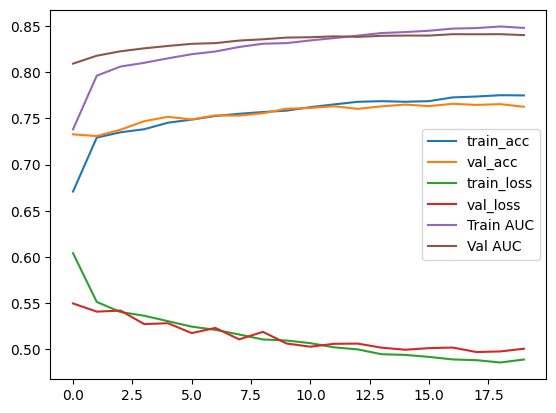


 Acc: 0.7625473484848485, MCC: 0.526833368718345, SN:0.8029836609045702, SP:0.7221301775147929, 
 CM:[[3051 1174]
 [ 832 3391]]


In [85]:
# Pretraining CNN

n_epo_cnn = 20

metrics = ['accuracy', tf.keras.metrics.AUC(name='auc_roc')]

model_A = CNN_model()
model_A.compile(optimizer=Adam(learning_rate=1e-3), loss=BinaryCrossentropy(), metrics=metrics)

#model_A.summary()

print("PRE Training CNN model...")

checkpointer = ModelCheckpoint(filepath="../models/pre_model_A.h5",
                                monitor = "val_accuracy",
                                verbose=0, 
                                save_weights_only=True,
                                save_best_only=True)

#early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=7,mode='auto')

pre_history_A = model_A.fit(pre_train_ST, pre_train_ST_labels, batch_size=256, epochs=n_epo_cnn, verbose=1, callbacks=[checkpointer],
    validation_data=(pre_test_ST, pre_test_ST_labels))

# Save model
#model_A.save_weights('../models/pre_model_A.h5')

y_pred = model_A.predict(pre_test_ST).reshape(pre_test_ST_labels.shape[0],)
y_pred = (y_pred > 0.5)
y_pred = [int(i) for i in y_pred]
a_pre_test_ST_labels = np.array(pre_test_ST_labels)
y_pred = np.array(y_pred)

cm = confusion_matrix(a_pre_test_ST_labels, y_pred)
mcc = matthews_corrcoef(a_pre_test_ST_labels, y_pred)
acc = accuracy_score(a_pre_test_ST_labels, y_pred)

sn = cm[1][1]/(cm[1][1]+cm[1][0])
sp = cm[0][0]/(cm[0][0]+cm[0][1])

#save plot
plot(pre_history_A)
print("\n Acc: %s, MCC: %s, SN:%s, SP:%s, \n CM:%s" %(str(acc), str(mcc), str(sn), str(sp), cm))

Pre Training Embedding model...
Epoch 1/20
132/132 [==============================] - 2s 8ms/step - loss: 0.5467 - accuracy: 0.7325 - auc_roc: 0.8016 - val_loss: 0.5075 - val_accuracy: 0.7595 - val_auc_roc: 0.8338
Epoch 2/20
132/132 [==============================] - 1s 7ms/step - loss: 0.5150 - accuracy: 0.7528 - auc_roc: 0.8267 - val_loss: 0.5034 - val_accuracy: 0.7634 - val_auc_roc: 0.8370
Epoch 3/20
132/132 [==============================] - 1s 7ms/step - loss: 0.5065 - accuracy: 0.7606 - auc_roc: 0.8331 - val_loss: 0.5003 - val_accuracy: 0.7653 - val_auc_roc: 0.8385
Epoch 4/20
132/132 [==============================] - 1s 7ms/step - loss: 0.5008 - accuracy: 0.7654 - auc_roc: 0.8372 - val_loss: 0.5025 - val_accuracy: 0.7704 - val_auc_roc: 0.8395
Epoch 5/20
132/132 [==============================] - 1s 7ms/step - loss: 0.4936 - accuracy: 0.7681 - auc_roc: 0.8425 - val_loss: 0.5027 - val_accuracy: 0.7627 - val_auc_roc: 0.8384
Epoch 6/20
132/132 [==============================] - 1s 7

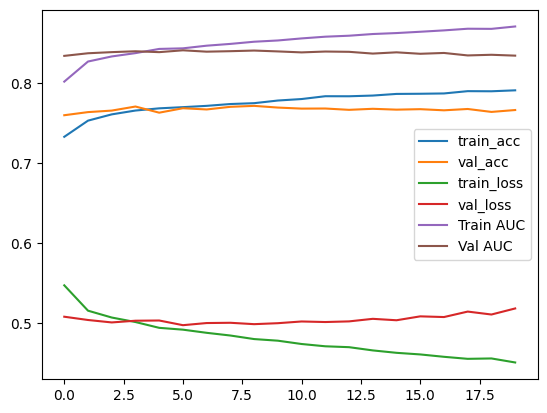


 Acc: 0.7660355029585799, MCC: 0.5321936551015639, SN:0.7764622306417239, SP:0.7556186420629288, 
 CM:[[3194 1033]
 [ 944 3279]]


 Acc: 0.7712426035502958, MCC: 0.5426580885904205, SN:0.7835661851764149, SP:0.7589306837000237, 
 CM:[[3208 1019]
 [ 914 3309]]


In [114]:
########### Model B

print("Pre Training Embedding model...")

metrics = ['accuracy', tf.keras.metrics.AUC(name='auc_roc')]
n_epo_embed = 20
model_B = prot_t5_model()
model_B.compile(optimizer=Adam(learning_rate=1e-3), loss=BinaryCrossentropy(), metrics=metrics)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, mode='auto')

checkpointer = ModelCheckpoint(filepath="../models/pre_model_B.h5",
                                monitor = "val_accuracy",
                                verbose=0, 
                                save_weights_only=True,
                                save_best_only=True)

history_B = model_B.fit(pre_train_ST_Embed, pre_train_ST_labels_Embed, batch_size=256, epochs=n_epo_embed, verbose=1, 
                        callbacks=[checkpointer], validation_data=(pre_test_ST_Embed, pre_test_ST_labels_Embed))

# pre_train_ST_Embed.shape, pre_train_ST_labels_Embed.shape
# pre_test_ST_Embed.shape, pre_test_ST_labels_Embed.shape
#model_B.save_weights('../models/re_train_model_B.h5')

y_pred = model_B.predict(pre_test_ST_Embed).reshape(pre_test_ST_labels_Embed.shape[0],)
y_pred = (y_pred > 0.5)
y_pred = [int(i) for i in y_pred]
pre_train_ST_labels_Embed = np.array(pre_train_ST_labels_Embed)
y_pred = np.array(y_pred)

cm = confusion_matrix(pre_test_ST_labels_Embed, y_pred)
mcc = matthews_corrcoef(pre_test_ST_labels_Embed, y_pred)
acc = accuracy_score(pre_test_ST_labels_Embed, y_pred)

sn = cm[1][1]/(cm[1][1]+cm[1][0])
sp = cm[0][0]/(cm[0][0]+cm[0][1])

plot(history_B)
print("\n Acc: %s, MCC: %s, SN:%s, SP:%s, \n CM:%s" %(str(acc), str(mcc), str(sn), str(sp), cm))
print()

loaded_model_B = prot_t5_model()
loaded_model_B.load_weights("../models/pre_model_B.h5")
y_pred = loaded_model_B.predict(pre_test_ST_Embed).reshape(pre_test_ST_labels_Embed.shape[0],)
y_pred = (y_pred > 0.5)
y_pred = [int(i) for i in y_pred]
pre_test_ST_labels_Embed = np.array(pre_test_ST_labels_Embed)
y_pred = np.array(y_pred)

cm = confusion_matrix(pre_test_ST_labels_Embed, y_pred)
mcc = matthews_corrcoef(pre_test_ST_labels_Embed, y_pred)
acc = accuracy_score(pre_test_ST_labels_Embed, y_pred)

sn = cm[1][1]/(cm[1][1]+cm[1][0])
sp = cm[0][0]/(cm[0][0]+cm[0][1])

print("\n Acc: %s, MCC: %s, SN:%s, SP:%s, \n CM:%s" %(str(acc), str(mcc), str(sn), str(sp), cm))

In [91]:
# transformer based embedding model
def transformer_model():
    vocab_size = 21
    embed_dim = 128 #config["embedding_dim"]
    ff_dim = 128 #config["feed_forward_dim"]
    max_len = 33 #config["maximum_path_length"]
    dropout = 0.4 #config["dropout"]
    n_heads = 2

    inputs = Input(shape=(max_len,))
    embedding_layer = TokenAndPositionEmbedding(max_len, vocab_size, embed_dim)
    x = embedding_layer(inputs)
    transformer_block = TransformerBlock(embed_dim, n_heads, ff_dim)
    x, weights = transformer_block(x)
    x = GlobalAveragePooling1D()(x) #GlobalAveragePooling1D
    x = Dropout(dropout)(x)
    x = Dense(ff_dim, activation="relu")(x)
    x = Dropout(dropout)(x)
    outputs = Dense(1, activation="sigmoid")(x)
    return Model(inputs=inputs, outputs=[outputs])

PRE Training Transformer model...
Epoch 1/20
132/132 [==============================] - 63s 456ms/step - loss: 0.6244 - accuracy: 0.6497 - auc_roc: 0.7372 - val_loss: 0.6004 - val_accuracy: 0.6795 - val_auc_roc: 0.7471
Epoch 2/20
132/132 [==============================] - 60s 454ms/step - loss: 0.5945 - accuracy: 0.6846 - auc_roc: 0.7424 - val_loss: 0.5550 - val_accuracy: 0.7183 - val_auc_roc: 0.7924
Epoch 3/20
132/132 [==============================] - 70s 531ms/step - loss: 0.5478 - accuracy: 0.7264 - auc_roc: 0.7968 - val_loss: 0.5287 - val_accuracy: 0.7373 - val_auc_roc: 0.8177
Epoch 4/20
132/132 [==============================] - 77s 583ms/step - loss: 0.5358 - accuracy: 0.7358 - auc_roc: 0.8078 - val_loss: 0.5154 - val_accuracy: 0.7505 - val_auc_roc: 0.8241
Epoch 5/20
132/132 [==============================] - 67s 506ms/step - loss: 0.5301 - accuracy: 0.7376 - auc_roc: 0.8126 - val_loss: 0.5302 - val_accuracy: 0.7358 - val_auc_roc: 0.8232
Epoch 6/20
132/132 [=====================

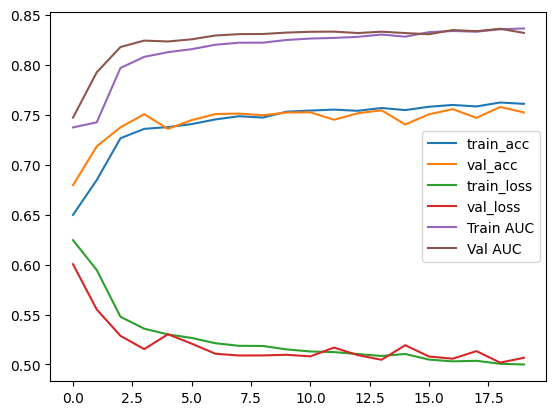


 Acc: 0.752249053030303, MCC: 0.5050646557597046, SN:0.7283921382903149, SP:0.7760946745562131, 
 CM:[[3279  946]
 [1147 3076]]


In [92]:
# Pretraining transformer

n_epo_transformer = 20
model_C = transformer_model()
model_C.compile(optimizer=Adam(learning_rate=1e-3), loss=BinaryCrossentropy(), metrics=metrics)

#model_C.summary()

checkpointer = ModelCheckpoint(filepath="../models/pre_model_C.h5",
                                monitor = "val_accuracy",
                                verbose=0, 
                                save_weights_only=True,
                                save_best_only=True)

print("PRE Training Transformer model...")

pre_history_C = model_C.fit(pre_train_ST, pre_train_ST_labels, batch_size=256, epochs=n_epo_transformer, verbose=1, callbacks=[checkpointer],
    validation_data=(pre_test_ST, pre_test_ST_labels))

# Save model
#model_C.save_weights('../models/pre_model_C.h5')

y_pred = model_C.predict(pre_test_ST).reshape(pre_test_ST_labels.shape[0],)
y_pred = (y_pred > 0.5)
y_pred = [int(i) for i in y_pred]
a_pre_test_ST_labels = np.array(pre_test_ST_labels)
y_pred = np.array(y_pred)

cm = confusion_matrix(a_pre_test_ST_labels, y_pred)
mcc = matthews_corrcoef(a_pre_test_ST_labels, y_pred)
acc = accuracy_score(a_pre_test_ST_labels, y_pred)

sn = cm[1][1]/(cm[1][1]+cm[1][0])
sp = cm[0][0]/(cm[0][0]+cm[0][1])

#save plot
plot(pre_history_C)
print("\n Acc: %s, MCC: %s, SN:%s, SP:%s, \n CM:%s" %(str(acc), str(mcc), str(sn), str(sp), cm))

In [93]:
## Predict on real data using CNN

y_pred = model_A.predict(X_test_CNN).reshape(test_ST_labels.shape[0],)
y_pred = (y_pred > 0.5)
y_pred = [int(i) for i in y_pred]
test_ST_labels = np.array(test_ST_labels)
y_pred = np.array(y_pred)

cm = confusion_matrix(test_ST_labels, y_pred)
mcc = matthews_corrcoef(test_ST_labels, y_pred)
acc = accuracy_score(test_ST_labels, y_pred)

sn = cm[1][1]/(cm[1][1]+cm[1][0])
sp = cm[0][0]/(cm[0][0]+cm[0][1])

print("\n Acc: %s, MCC: %s, SN:%s, SP:%s, \n CM:%s" %(str(acc), str(mcc), str(sn), str(sp), cm))

## Predict on real data using transformers

y_pred = model_C.predict(X_test_CNN).reshape(test_ST_labels.shape[0],)
y_pred = (y_pred > 0.5)
y_pred = [int(i) for i in y_pred]
test_ST_labels = np.array(test_ST_labels)
y_pred = np.array(y_pred)

cm = confusion_matrix(test_ST_labels, y_pred)
mcc = matthews_corrcoef(test_ST_labels, y_pred)
acc = accuracy_score(test_ST_labels, y_pred)

sn = cm[1][1]/(cm[1][1]+cm[1][0])
sp = cm[0][0]/(cm[0][0]+cm[0][1])

print("\n Acc: %s, MCC: %s, SN:%s, SP:%s, \n CM:%s" %(str(acc), str(mcc), str(sn), str(sp), cm))


 Acc: 0.8004484304932735, MCC: 0.6096230453902978, SN:0.8828828828828829, SP:0.71875, 
 CM:[[161  63]
 [ 26 196]]

 Acc: 0.7802690582959642, MCC: 0.5606792863501016, SN:0.7657657657657657, SP:0.7946428571428571, 
 CM:[[178  46]
 [ 52 170]]


Training CNN model...
Epoch 1/50
7/7 [==============================] - 2s 128ms/step - loss: 0.5322 - accuracy: 0.7476 - auc_roc: 0.8285 - val_loss: 0.4702 - val_accuracy: 0.7960 - val_auc_roc: 0.8837
Epoch 2/50
7/7 [==============================] - 1s 77ms/step - loss: 0.5161 - accuracy: 0.7527 - auc_roc: 0.8276 - val_loss: 0.4517 - val_accuracy: 0.7982 - val_auc_roc: 0.8882
Epoch 3/50
7/7 [==============================] - 1s 84ms/step - loss: 0.4983 - accuracy: 0.7600 - auc_roc: 0.8383 - val_loss: 0.4511 - val_accuracy: 0.8004 - val_auc_roc: 0.8900
Epoch 4/50
7/7 [==============================] - 1s 86ms/step - loss: 0.4860 - accuracy: 0.7690 - auc_roc: 0.8494 - val_loss: 0.4460 - val_accuracy: 0.8004 - val_auc_roc: 0.8909
Epoch 5/50
7/7 [==============================] - 1s 90ms/step - loss: 0.4832 - accuracy: 0.7701 - auc_roc: 0.8497 - val_loss: 0.4471 - val_accuracy: 0.7915 - val_auc_roc: 0.8924
Epoch 6/50
7/7 [==============================] - 1s 92ms/step - loss: 0.4847 - ac

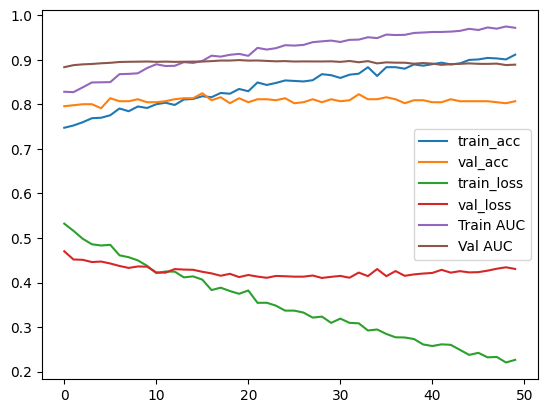


 Acc: 0.8071748878923767, MCC: 0.6146110083292221, SN:0.8198198198198198, SP:0.7946428571428571, 
 CM:[[178  46]
 [ 40 182]]



In [94]:
# Training DE-Phosphorylation

iteration = 1
n_epo_cnn = 50

model_A = CNN_model()
model_A.compile(optimizer=Adam(learning_rate=1e-3), loss=BinaryCrossentropy(), metrics=metrics)
model_A.load_weights('../models/pre_model_A.h5')
#model_A.summary()

print("Training CNN model...")

#metrics = ['accuracy', tf.keras.metrics.AUC()]

#early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=7,mode='auto')

checkpointer = ModelCheckpoint(filepath="../models/re_train_model_A.h5",
                                monitor = "val_accuracy",
                                verbose=0, 
                                save_weights_only=True,
                                save_best_only=True)

history_A = model_A.fit(X_train_CNN, train_ST_labels, batch_size=256, epochs=n_epo_cnn, verbose=1, callbacks=[checkpointer], 
                        validation_data=(X_test_CNN, test_ST_labels))

# Save model
#model_A.save_weights('../models/re_train_model_A.h5')

y_pred = model_A.predict(X_test_CNN).reshape(test_ST_labels.shape[0],)
y_pred = (y_pred > 0.5)
y_pred = [int(i) for i in y_pred]
test_ST_labels = np.array(test_ST_labels)
y_pred = np.array(y_pred)

cm = confusion_matrix(test_ST_labels, y_pred)
mcc = matthews_corrcoef(test_ST_labels, y_pred)
acc = accuracy_score(test_ST_labels, y_pred)

sn = cm[1][1]/(cm[1][1]+cm[1][0])
sp = cm[0][0]/(cm[0][0]+cm[0][1])

#save plot
plot(history_A)
print("\n Acc: %s, MCC: %s, SN:%s, SP:%s, \n CM:%s" %(str(acc), str(mcc), str(sn), str(sp), cm))
print()

In [95]:
loaded_model_A = CNN_model()
loaded_model_A.load_weights("../models/re_train_model_A.h5")
y_pred = loaded_model_A.predict(X_test_CNN).reshape(test_ST_labels.shape[0],)
y_pred = (y_pred > 0.5)
y_pred = [int(i) for i in y_pred]
test_ST_labels = np.array(test_ST_labels)
y_pred = np.array(y_pred)

cm = confusion_matrix(test_ST_labels, y_pred)
mcc = matthews_corrcoef(test_ST_labels, y_pred)
acc = accuracy_score(test_ST_labels, y_pred)

sn = cm[1][1]/(cm[1][1]+cm[1][0])
sp = cm[0][0]/(cm[0][0]+cm[0][1])

print("\n Acc: %s, MCC: %s, SN:%s, SP:%s, \n CM:%s" %(str(acc), str(mcc), str(sn), str(sp), cm))


 Acc: 0.8251121076233184, MCC: 0.6512447370849092, SN:0.8513513513513513, SP:0.7991071428571429, 
 CM:[[179  45]
 [ 33 189]]


Training Embedding model...
Epoch 1/20
7/7 [==============================] - 1s 40ms/step - loss: 0.4978 - accuracy: 0.7684 - auc_roc: 0.8427 - val_loss: 0.4293 - val_accuracy: 0.8184 - val_auc_roc: 0.8873
Epoch 2/20
7/7 [==============================] - 0s 13ms/step - loss: 0.4727 - accuracy: 0.7774 - auc_roc: 0.8577 - val_loss: 0.4326 - val_accuracy: 0.8318 - val_auc_roc: 0.8853
Epoch 3/20
7/7 [==============================] - 0s 14ms/step - loss: 0.4441 - accuracy: 0.8010 - auc_roc: 0.8744 - val_loss: 0.4276 - val_accuracy: 0.8341 - val_auc_roc: 0.8886
Epoch 4/20
7/7 [==============================] - 0s 11ms/step - loss: 0.4217 - accuracy: 0.8049 - auc_roc: 0.8875 - val_loss: 0.4273 - val_accuracy: 0.8274 - val_auc_roc: 0.8865
Epoch 5/20
7/7 [==============================] - 0s 11ms/step - loss: 0.4103 - accuracy: 0.8106 - auc_roc: 0.8926 - val_loss: 0.4263 - val_accuracy: 0.8318 - val_auc_roc: 0.8876
Epoch 6/20
7/7 [==============================] - 0s 11ms/step - loss: 0.4056

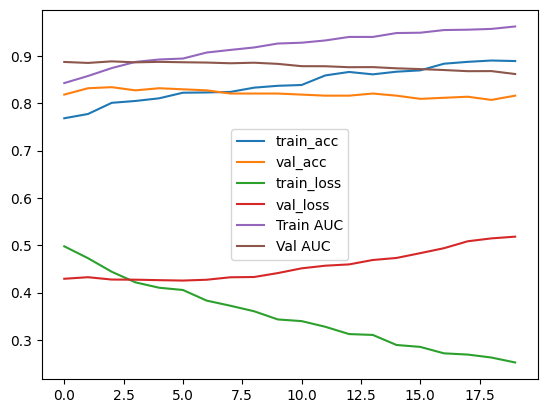


 Acc: 0.8340807174887892, MCC: 0.6681949806949807, SN:0.8378378378378378, SP:0.8303571428571429, 
 CM:[[186  38]
 [ 36 186]]


 Acc: 0.8340807174887892, MCC: 0.6683567494097307, SN:0.8198198198198198, SP:0.8482142857142857, 
 CM:[[190  34]
 [ 40 182]]


In [164]:
########### Model B

print("Training Embedding model...")

n_epo_embed = 20
model_B = prot_t5_model()
model_B.compile(optimizer=Adam(learning_rate=1e-3), loss=BinaryCrossentropy(), metrics=metrics)
model_B.load_weights('../models/pre_model_B.h5')

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, mode='auto')

checkpointer = ModelCheckpoint(filepath="../models/re_train_model_B.h5",
                                monitor = "val_accuracy",
                                verbose=0, 
                                save_weights_only=True,
                                save_best_only=True)

history_B = model_B.fit(X_train_full_ST_embedding, train_ST_labels, batch_size=256, epochs=n_epo_embed, verbose=1, 
                        callbacks=[checkpointer], validation_data=(X_test_full_ST_embedding, test_ST_labels))

plot(history_B)
print("\n Acc: %s, MCC: %s, SN:%s, SP:%s, \n CM:%s" %(str(acc), str(mcc), str(sn), str(sp), cm))
print()

loaded_model_B = prot_t5_model()
loaded_model_B.load_weights("../models/re_train_model_B.h5")
y_pred = loaded_model_B.predict(X_test_full_ST_embedding).reshape(test_ST_labels.shape[0],)
y_pred = (y_pred > 0.5)
y_pred = [int(i) for i in y_pred]
test_ST_labels = np.array(test_ST_labels)
y_pred = np.array(y_pred)

cm = confusion_matrix(test_ST_labels, y_pred)
mcc = matthews_corrcoef(test_ST_labels, y_pred)
acc = accuracy_score(test_ST_labels, y_pred)

sn = cm[1][1]/(cm[1][1]+cm[1][0])
sp = cm[0][0]/(cm[0][0]+cm[0][1])

print("\n Acc: %s, MCC: %s, SN:%s, SP:%s, \n CM:%s" %(str(acc), str(mcc), str(sn), str(sp), cm))

Model: "model_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 33)]              0         
                                                                 
 token_and_position_embeddin  (None, 33, 128)          6912      
 g_2 (TokenAndPositionEmbedd                                     
 ing)                                                            
                                                                 
 transformer_block_2 (Transf  ((None, 33, 128),        214912    
 ormerBlock)                  (None, 2, 33, 33))                 
                                                                 
 global_average_pooling1d_2   (None, 128)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_50 (Dropout)        (None, 128)               0  

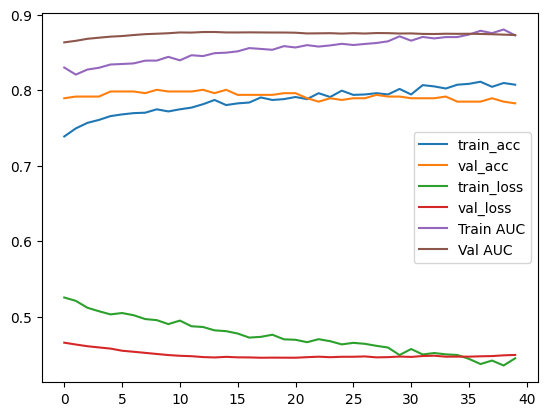


 Acc: 0.7825112107623319, MCC: 0.5653534311961879, SN:0.7972972972972973, SP:0.7678571428571429, 
 CM:[[172  52]
 [ 45 177]]


 Acc: 0.8004484304932735, MCC: 0.6017092874945692, SN:0.8243243243243243, SP:0.7767857142857143, 
 CM:[[174  50]
 [ 39 183]]


In [97]:
############# Training Transformer


model_C = transformer_model()
model_C.load_weights('../models/pre_model_C.h5')
model_C.compile(optimizer=Adam(learning_rate=1e-4), loss=BinaryCrossentropy(), metrics=metrics)

model_C.summary()

n_epo_transformer = 40

print("Training Transformer model...")

checkpointer = ModelCheckpoint(filepath="../models/re_train_model_C.h5",
                                monitor = "val_accuracy",
                                verbose=0, 
                                save_weights_only=True,
                                save_best_only=True)

#early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=7,mode='auto')

history_C = model_C.fit(X_train_CNN, train_ST_labels, batch_size=256, epochs=n_epo_transformer, verbose=1
                        ,callbacks=[checkpointer]
                        , validation_data=(X_test_CNN, test_ST_labels))

#save plot
plot(history_C)
print("\n Acc: %s, MCC: %s, SN:%s, SP:%s, \n CM:%s" %(str(acc), str(mcc), str(sn), str(sp), cm))
print()

loaded_model_C = transformer_model()
loaded_model_C.load_weights("../models/re_train_model_C.h5")
y_pred = loaded_model_C.predict(X_test_CNN).reshape(test_ST_labels.shape[0],)
y_pred = (y_pred > 0.5)
y_pred = [int(i) for i in y_pred]
test_ST_labels = np.array(test_ST_labels)
y_pred = np.array(y_pred)

cm = confusion_matrix(test_ST_labels, y_pred)
mcc = matthews_corrcoef(test_ST_labels, y_pred)
acc = accuracy_score(test_ST_labels, y_pred)

sn = cm[1][1]/(cm[1][1]+cm[1][0])
sp = cm[0][0]/(cm[0][0]+cm[0][1])

print("\n Acc: %s, MCC: %s, SN:%s, SP:%s, \n CM:%s" %(str(acc), str(mcc), str(sn), str(sp), cm))

In [165]:
# load models from file
def load_A_models():
    model = CNN_model()
    model.load_weights('../models/re_train_model_A.h5')
    return model


def load_B_models():
    model = prot_t5_model()
    model.load_weights('../models/re_train_model_B.h5')
    return model


def load_C_models():
    model = transformer_model()
    model.load_weights('../models/re_train_model_C.h5')
    return model


# meta learner
def define_stacked_model(members):
    for i in range(len(members)):
        model = members[i]
        for layer in model.layers:
            layer.trainable = False
    ensemble_inputs = [model.input for model in members]
    ensemble_outputs = [model.output for model in members]
    #[model.get_layer(index = len(model.layers) - 2).output for model in members]
    #print(ensemble_outputs)
    #for item in ensemble_outputs:
    #    print(item)
    # outputs=re_stacked_model.get_layer(index=26).output
    merge = concatenate(ensemble_outputs)
    #hidden = Dropout(0.4, name = 'dp_2')(merge)
    #hidden = Dense(256, activation='relu', name = 'ds_1')(merge)
    #hidden = Dropout(0.4, name = 'dp_1')(hidden)
    hidden = Dense(256, activation='relu', name = 'ds_2')(merge)
    hidden = Dropout(0.4, name = 'dp_1')(hidden)
    output = Dense(1, activation='sigmoid', name = 'ds_4')(hidden)
    model = Model(inputs=ensemble_inputs, outputs=output)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=metrics)
    #model.summary()
    return model


# load all models
members = list()
model_A = load_A_models()
model_B = load_B_models()
model_C = load_C_models()

members.append(model_A)
members.append(model_B)
members.append(model_C)

n_epo_stacked = 20


print('Loaded %d models' % len(members))
stacked_model = define_stacked_model(members)


checkpointer = ModelCheckpoint(filepath="../models/pre_re_train_composite_model.h5",
                                monitor = "val_accuracy",
                                verbose=0, 
                                save_weights_only=True,
                                save_best_only=True)


st_history = stacked_model.fit([X_train_CNN, X_train_full_ST_embedding, X_train_CNN], train_ST_labels, 
                               epochs=n_epo_stacked, verbose=1, callbacks = [checkpointer],
                               validation_data=([X_test_CNN, X_test_full_ST_embedding, X_test_CNN], test_ST_labels))

# X_train_full_ST_embedding, X_test_full_ST_embedding


Loaded 3 models
Epoch 1/20
56/56 [==============================] - 3s 25ms/step - loss: 0.6073 - accuracy: 0.6402 - auc_roc: 0.8565 - val_loss: 0.5524 - val_accuracy: 0.7444 - val_auc_roc: 0.9078
Epoch 2/20
56/56 [==============================] - 1s 19ms/step - loss: 0.4975 - accuracy: 0.8139 - auc_roc: 0.9028 - val_loss: 0.4553 - val_accuracy: 0.8229 - val_auc_roc: 0.9079
Epoch 3/20
56/56 [==============================] - 1s 20ms/step - loss: 0.4215 - accuracy: 0.8331 - auc_roc: 0.9072 - val_loss: 0.4080 - val_accuracy: 0.8408 - val_auc_roc: 0.9081
Epoch 4/20
56/56 [==============================] - 1s 19ms/step - loss: 0.3865 - accuracy: 0.8274 - auc_roc: 0.9133 - val_loss: 0.3920 - val_accuracy: 0.8386 - val_auc_roc: 0.9083
Epoch 5/20
56/56 [==============================] - 1s 19ms/step - loss: 0.3829 - accuracy: 0.8342 - auc_roc: 0.9114 - val_loss: 0.3886 - val_accuracy: 0.8453 - val_auc_roc: 0.9080
Epoch 6/20
56/56 [==============================] - 1s 19ms/step - loss: 0.3753

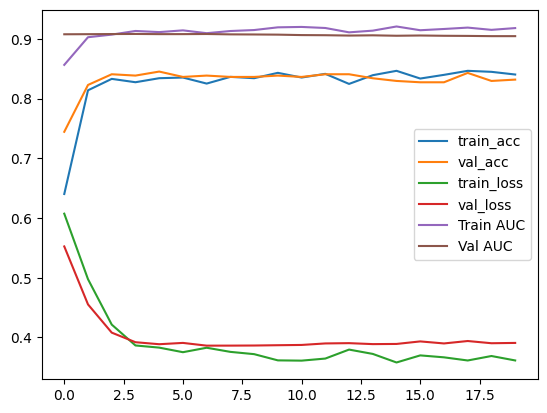



 Acc: 0.8452914798206278, MCC: 0.6905899032091436, SN:0.8468468468468469, SP:0.84375, 
 CM:[[189  35]
 [ 34 188]]


In [166]:
plot(st_history)
print()

# Predict
re_stacked_model = define_stacked_model(members)
re_stacked_model.load_weights("../models/pre_re_train_composite_model.h5")
y_pred = re_stacked_model.predict([X_test_CNN, X_test_full_ST_embedding, X_test_CNN]).reshape(test_ST_labels.shape[0],)
y_pred = (y_pred > 0.5)
y_pred = [int(i) for i in y_pred]
test_ST_labels = np.array(test_ST_labels)
y_pred = np.array(y_pred)

cm = confusion_matrix(test_ST_labels, y_pred)
mcc = matthews_corrcoef(test_ST_labels, y_pred)
acc = accuracy_score(test_ST_labels, y_pred)

sn = cm[1][1]/(cm[1][1]+cm[1][0])
sp = cm[0][0]/(cm[0][0]+cm[0][1])

print("\n Acc: %s, MCC: %s, SN:%s, SP:%s, \n CM:%s" %(str(acc), str(mcc), str(sn), str(sp), cm))

In [167]:
# load pretrained model
from tensorflow.keras.models import Sequential, load_model, Model
from sklearn.manifold import TSNE
from matplotlib.pyplot import figure
import pandas as pd
import seaborn as sns
import h5py

#re_stacked_model.summary()

print("Number of layers: ", len(re_stacked_model.layers))

# create truncated model
truncated_ANN_model = Model(inputs=re_stacked_model.input,
                                 outputs=re_stacked_model.get_layer(index=len(re_stacked_model.layers) - 1).output) #20

hidden_features = truncated_CNN_model.predict([X_test_full_ST_embedding])

hidden_labels = test_ST_labels #train_ST_labels

print(hidden_features.shape)

df = pd.DataFrame()
df['Target'] = hidden_labels

Number of layers:  28
(446, 64)


/home/anupkumar/anaconda3/envs/succsite/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


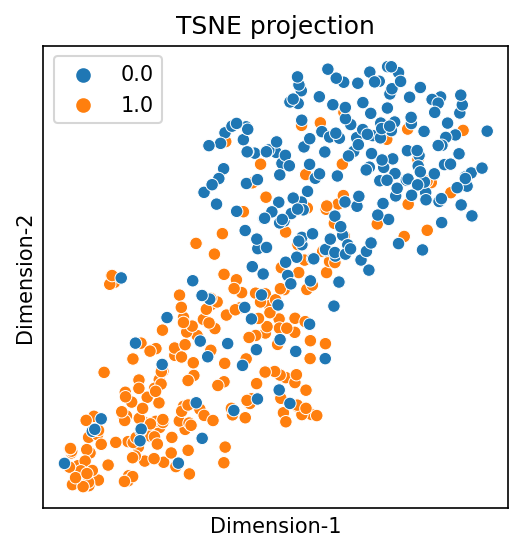

In [168]:
m = TSNE(learning_rate = "auto", perplexity = 100, random_state = 20)
tsne_features = m.fit_transform(hidden_features)
df['Dimension-1'] = tsne_features[:,0]
df['Dimension-2'] = tsne_features[:,1]

figsize = (4, 4)
figure(figsize=figsize, dpi=150)

sns.scatterplot(x="Dimension-1", y="Dimension-2", hue='Target',data=df)
plt.tick_params(top=False,
               bottom=False,
               left=False,
               right=False,
               labelleft=False,
               labelbottom=False)

plt.title("TSNE projection")
plt.legend().set_visible(True)
filename = "TSNE_Embedding_Pos_Neg.png"
plt.savefig(filename, dpi=150, bbox_inches='tight')
plt.show()

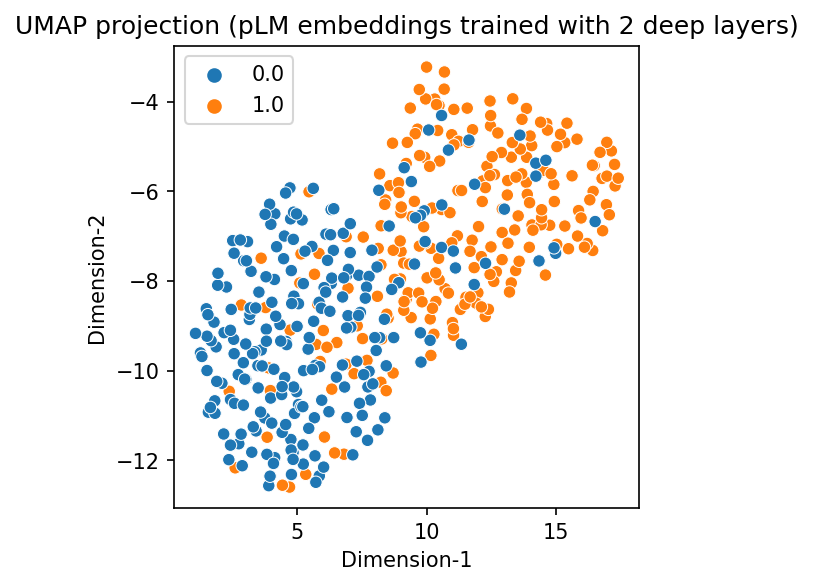

In [169]:
from umap import UMAP
from matplotlib.pyplot import figure

figsize = (4, 4)
figure(figsize=figsize, dpi=150)

n_colors = 10

n_neighbors = 100

min_dist = 0.99

n_components = 2

metric = "hsl_dist" #'euclidean'

umap_2d = UMAP(n_components=n_components, n_neighbors = n_neighbors, min_dist = min_dist, init = 'random', random_state = 0)

proj_2d = umap_2d.fit_transform(hidden_features)

df_umap = pd.DataFrame()

df_umap["Dimension-1"] = proj_2d[:,0]
df_umap["Dimension-2"] = proj_2d[:,1]

sns_plot = sns.scatterplot(x="Dimension-1", y="Dimension-2", hue=hidden_labels, data=df_umap).set(title="UMAP projection (pLM embeddings trained with 2 deep layers)")
filename = "UMAP_Embedding_Pos_Neg.png"
plt.savefig(filename, dpi=150, bbox_inches='tight')

/home/anupkumar/anaconda3/envs/succsite/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


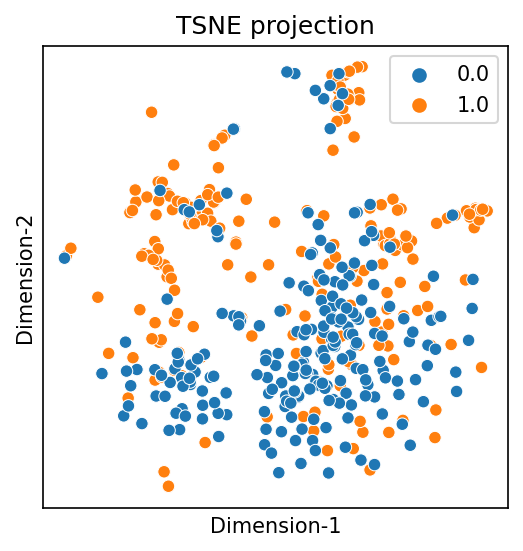

In [170]:
hidden_features_raw = X_test_full_ST_embedding
df = pd.DataFrame()
df['Target'] = test_ST_labels

m_raw = TSNE(learning_rate = "auto", perplexity = 100, random_state = 20)

tsne_features = m_raw.fit_transform(hidden_features_raw)

df['Dimension-1'] = tsne_features[:,0]
df['Dimension-2'] = tsne_features[:,1]

figsize = (4, 4)
figure(figsize=figsize, dpi=150)

sns.scatterplot(x="Dimension-1", y="Dimension-2", hue='Target',data=df)
plt.tick_params(top=False,
               bottom=False,
               left=False,
               right=False,
               labelleft=False,
               labelbottom=False)

plt.title("TSNE projection")
plt.legend().set_visible(True)
filename = "TSNE_Embedding_Pos_Neg_Raw.png"
plt.savefig(filename, dpi=150, bbox_inches='tight')
plt.show()

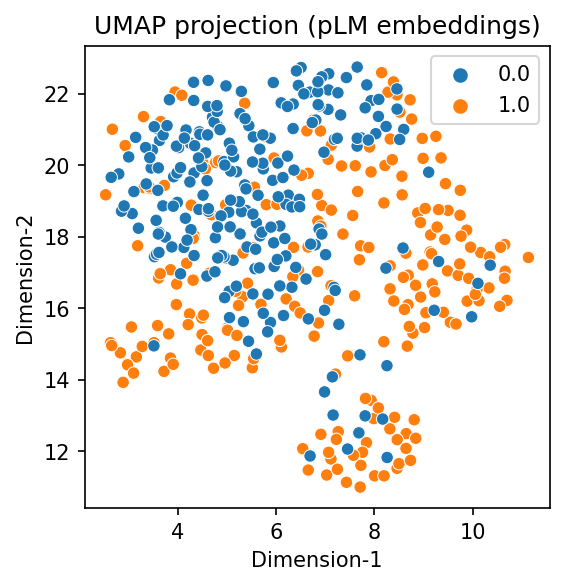

In [171]:

figsize = (4, 4)
figure(figsize=figsize, dpi=150)

n_colors = 10

#n_neighbors = 1000

#min_dist = 0.99

#n_components=2

#metric='euclidean'

umap_2d_raw = UMAP(n_components=n_components, n_neighbors=n_neighbors, min_dist=min_dist, init='random', random_state=0)

proj_2d = umap_2d_raw.fit_transform(hidden_features_raw)

df_umap = pd.DataFrame()

df_umap["Dimension-1"] = proj_2d[:,0]
df_umap["Dimension-2"] = proj_2d[:,1]

sns_plot = sns.scatterplot(x="Dimension-1", y="Dimension-2", hue=hidden_labels, data=df_umap).set(title="UMAP projection (pLM embeddings)")
filename = "UMAP_Embedding_Pos_Neg_pLM_embeddings.png"
plt.savefig(filename, dpi=150, bbox_inches='tight')